# Which GPU to use

In [1]:
multiGPU = False
whichGPU = 1
 
# Select which GPU to use
if(multiGPU):
    from keras.utils.training_utils import multi_gpu_model
else:
    import os
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
    # The GPU id to use, usually either "0" or "1"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(whichGPU)
    
# # Do other imports now...

# Load all the functions

In [2]:
%run -i 'arena.py'

Using TensorFlow backend.


# General Parameters

In [3]:
import math

# What data to use
tableBase = '4PpKk'
convertStates = False

# Interactive (just in general if one is asked for confirmations, set to False if on autopilot over night f.x.)
askForConfirmation = False

# NN parameters
filters = [16,32,32,64,128,128,128]
filterShape = [2,2,2,2,2,2,2]
batch_size = 256
optimizer = 'Adadelta'
useBatchNorm = False
num_classes = 3
input_shape = (4,8,8)

### DON'T MODIFY BELOW ###
# Generate dataset variables
fileName = tableBase + '.hdf5'
dataSetName = tableBase + '_onlyLegal'
if not convertStates: 
    dataSetName = tableBase + '_onlyLegal_fullStates'
dataSetWdlName = tableBase + '_Wdl_onlyLegal_3Values'

# Number of Pieces
nPi =  int(dataSetName[0])
nPa = nPi - 2
nWPa = math.ceil(nPa/2)

# Experiment 1
Bengio methood 3n4 with freeze

### Exp 1 Paramters

In [4]:
%run -i 'arena.py'

# Parameters
sourceNet = '103' # trained on 3pc from scratch
# sourceNet = '107' # trained on 4pc from scratch
freeze = True
resSaveFile = '3n4freeze'
epochs = 10
averageOver = 10
expDescrBaseName = "Bengio 3n4 - freeze = {} - average over {} runs".format(str(freeze), averageOver)

saveEveryRun = True # save stuff in results dir
saveWeightsCheckpoints = False # save chkp in results dit
saveTensorboardLogs = True # save logs in ./logs dir
resID = '---NORESID---' # used when not saving data, but fitModel() still needs a resID

fractionOfDataToUse = 1
plotDuringTraining = False
loadWeights = False 
askForConfirmation = False
saveDir = 'bengioResults'

resSaveFile = resSaveFile + '-{}runAverage'.format(averageOver)
resSaveFileFullPath = saveDir + '/' + str(resSaveFile) + '.pkl' 

### Create model and load data

In [5]:
# prepare save file
if not os.path.exists(resSaveFileFullPath):
    print("Save file doesn't exists, creating...\n")
    save_obj(saveDir, resSaveFile, [])
else:
    print("Save file exists...\n")


# load data
X_train, X_test, y_train, y_test = loadData()

# create model
model, nnStr = createModel()
layersCount = len(model.layers)

# load old results
results = load_obj(saveDir, resSaveFile)

# initialize variables wrt old results
startTrainingAtLayer = len(results)
print("\nStarting/restarting TL at {} transfered layers".format(startTrainingAtLayer))

Save file exists...

X_train shape: (4982178, 4, 8, 8)
y_train shape: (4982178, 1)
X_test shape: (2453910, 4, 8, 8)
y_test shape: (2453910, 1)
4982178 train samples
2453910 test samples
Done loading dataset
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 7, 7)          272       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 6, 32)         928       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 5, 32)         4128      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 4, 64)         8256      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 3, 128)        32896     
_________________________________________________________________
c

### Train

In [6]:
%run -i 'arena.py'

for copyFirstNLayers in range(startTrainingAtLayer, layersCount):
    print('\n\n')
    print('==========================================================================================')
    print('=                                                                                        =')
    print('=                    Currently transfering first {} layers, out of {}                      ='.format(copyFirstNLayers, layersCount - 1))
    print('=                                                                                        =')
    print('==========================================================================================')
    print()
    
    # check if we are at the flatten layer, and skip it if so
    if copyFirstNLayers == layersCount - 1:
        copyFirstNLayers += 1
        
    # train and average results
    accumulatedScore = 0
    for a in range(averageOver):
        
        # set experement description test
        expDescr = expDescrBaseName + '__copyLayers_{}__average_{}_of_{}'.format(copyFirstNLayers, a+1, averageOver)        
        # save current averagePosition to tmp file
        with open(saveDir + '/' + str(resSaveFile) + '_currentPosition.txt','w') as file:
            if copyFirstNLayers == layersCount:
                location = copyFirstNLayers - 1
            else:
                location = copyFirstNLayers 
            file.write('Layers Transfered: {} out of {} \nInner avg loop position: {} out of {}'.format(location, layersCount-1, a+1, averageOver))         
            
        # load Model layers
        model = loadNFirstLayers(model, sourceNet, copyFirstNLayers , freeze)

        # Prepare save dir
        if saveEveryRun:
            resID = genNextResultsDir(model)

        # train
        fitHistory, logDir = trainModel(resID, model, saveWeightsCheckpoints, saveTensorboardLogs)

        # score and save results
        score = calcScore(model)
        if saveEveryRun:
            saveTrainResults(resID, model, logDir, score, copyFirstNLayers)

        # update Return
        accumulatedScore += score[1]
        
    # append averaged results for one set of layers
    results.append(accumulatedScore/averageOver)

    # save old results to checkpoints dir
    dateTime = time.strftime('%Y-%m-%d-%H:%M:%S', time.localtime())
    src = saveDir + '/' + str(resSaveFile) + '.txt'
    dest = saveDir + '/checkpoints/' + str(resSaveFile) + dateTime + '.txt'
    if os.path.exists(src):
        shutil.move(src, dest)

    # save results 
    save_obj(saveDir, resSaveFile, results)
    with open(saveDir + '/' + str(resSaveFile) + '.txt','w') as file:
        file.write(str(results))

    # to load:
    # results = load_obj('temp','3n4.txt')
print('\n Final Results: {}'.format(results))


 Final Results: [0.9659286607903355, 0.9716406877187543, 0.9707651869872542, 0.9715524611741639, 0.8524379052206138, 0.7808891524139756, 0.7279376586752997, 0.7232328814014212, 0.7231817792827615]


# Experiment 2
Bengio methood 4n4 with freeze

### Exp 2 Paramters

In [7]:
%run -i 'arena.py'

# Parameters
# sourceNet = '103' # trained on 3pc from scratch
sourceNet = '107' # trained on 4pc from scratch
freeze = True
resSaveFile = '4n4freeze'
epochs = 10
averageOver = 10
expDescrBaseName = "Bengio 4n4 - freeze = {} - average over {} runs".format(str(freeze), averageOver)

saveEveryRun = True # save stuff in results dir
saveWeightsCheckpoints = False # save chkp in results dit
saveTensorboardLogs = True # save logs in ./logs dir
resID = '---NORESID---' # used when not saving data, but fitModel() still needs a resID

fractionOfDataToUse = 1
plotDuringTraining = False
loadWeights = False 
askForConfirmation = False
saveDir = 'bengioResults'

resSaveFile = resSaveFile + '-{}runAverage'.format(averageOver)
resSaveFileFullPath = saveDir + '/' + str(resSaveFile) + '.pkl' 

### Create model and load data

In [8]:
# prepare save file
if not os.path.exists(resSaveFileFullPath):
    print("Save file doesn't exists, creating...\n")
    save_obj(saveDir, resSaveFile, [])
else:
    print("Save file exists...\n")


# load data
X_train, X_test, y_train, y_test = loadData()

# create model
model, nnStr = createModel()
layersCount = len(model.layers)

# load old results
results = load_obj(saveDir, resSaveFile)

# initialize variables wrt old results
startTrainingAtLayer = len(results)
print("\nStarting/restarting TL at {} transfered layers".format(startTrainingAtLayer))

Save file exists...

X_train shape: (4982178, 4, 8, 8)
y_train shape: (4982178, 1)
X_test shape: (2453910, 4, 8, 8)
y_test shape: (2453910, 1)
4982178 train samples
2453910 test samples
Done loading dataset
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 16, 7, 7)          272       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 6, 32)         928       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 5, 32)         4128      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 13, 4, 64)         8256      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 12, 3, 128)        32896     
_________________________________________________________________
c

### Train




=                                                                                        =
=                    Currently transfering first 3 layers, out of 8                      =
=                                                                                        =

- 1: Freezing layer <keras.layers.convolutional.Conv2D object at 0x7f2121cadd30>
- 2: Freezing layer <keras.layers.convolutional.Conv2D object at 0x7f2121d0a6a0>
- 3: Freezing layer <keras.layers.convolutional.Conv2D object at 0x7f2121e90f98>
- 4: Resetting layer <keras.layers.convolutional.Conv2D object at 0x7f2121cde6d8>
- 5: Resetting layer <keras.layers.convolutional.Conv2D object at 0x7f211f913390>
- 6: Resetting layer <keras.layers.convolutional.Conv2D object at 0x7f2125fb7a90>
- 7: Resetting layer <keras.layers.convolutional.Conv2D object at 0x7f2121c6e4a8>
- 8: Skipping layer <keras.layers.core.Flatten object at 0x7f2121c88470>
- 9: Resetting layer <keras.layers.core.Dense object at 0x7f2121c88908>
Save di

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4982178/4982178 [==============================] - 131s 26us/step - loss: 0.1951 - acc: 0.9200 - val_loss: 0.2088 - val_acc: 0.9139
Epoch 9/10
3180288/4982178 [==================>...........] - ETA: 41s - loss: 0.1894 - acc: 0.9225

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4982178/4982178 [==============================] - 132s 26us/step - loss: 0.3394 - acc: 0.8554 - val_loss: 0.3158 - val_acc: 0.8661
Epoch 3/10
4982178/4982178 [==============================] - 131s 26us/step - loss: 0.2947 - acc: 0.8760 - val_loss: 0.2881 - val_acc: 0.8793
Epoch 4/10
1180416/4982178 [======>.......................] - ETA: 1:27 - loss: 0.2755 - acc: 0.8849

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4982178/4982178 [==============================] - 131s 26us/step - loss: 0.2260 - acc: 0.9067 - val_loss: 0.2317 - val_acc: 0.9043
Epoch 9/10
4982178/4982178 [==============================] - 132s 27us/step - loss: 0.2192 - acc: 0.9096 - val_loss: 0.2281 - val_acc: 0.9061
Epoch 10/10
4982178/4982178 [==============================] - 132s 27us/step - loss: 0.2136 - acc: 0.9121 - val_loss: 0.2267 - val_acc: 0.9071
Training done
Calculating score
2453910/2453910 [==============================] - 115s 47us/step
(4982178, 4, 8, 8)
Evaluated test loss: 0.22670621998630974
Evaluated test accuracy: 0.9071249556829227
Saving results to dir 568
Saving history...
Saving weights...
Saving figures...


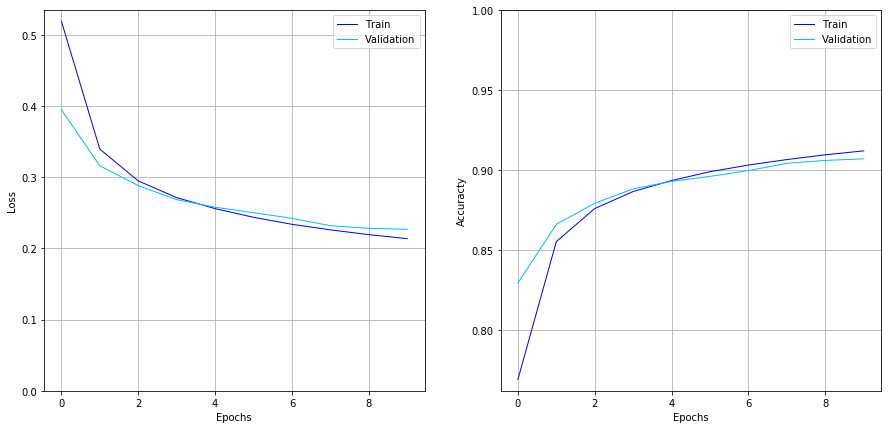

Saving summary...
Saving tensorboard logs...
All done saving stuff!
- 1: Freezing layer <keras.layers.convolutional.Conv2D object at 0x7f2121cadd30>
- 2: Freezing layer <keras.layers.convolutional.Conv2D object at 0x7f2121d0a6a0>
- 3: Freezing layer <keras.layers.convolutional.Conv2D object at 0x7f2121e90f98>
- 4: Resetting layer <keras.layers.convolutional.Conv2D object at 0x7f2121cde6d8>
- 5: Resetting layer <keras.layers.convolutional.Conv2D object at 0x7f211f913390>
- 6: Resetting layer <keras.layers.convolutional.Conv2D object at 0x7f2125fb7a90>
- 7: Resetting layer <keras.layers.convolutional.Conv2D object at 0x7f2121c6e4a8>
- 8: Skipping layer <keras.layers.core.Flatten object at 0x7f2121c88470>
- 9: Resetting layer <keras.layers.core.Dense object at 0x7f2121c88908>
Save dir: Results/570/
Creating save dir
Done generating results dir Results/570/
Train on 4982178 samples, validate on 2453910 samples
Epoch 1/10
4982178/4982178 [==============================] - 134s 27us/step - l

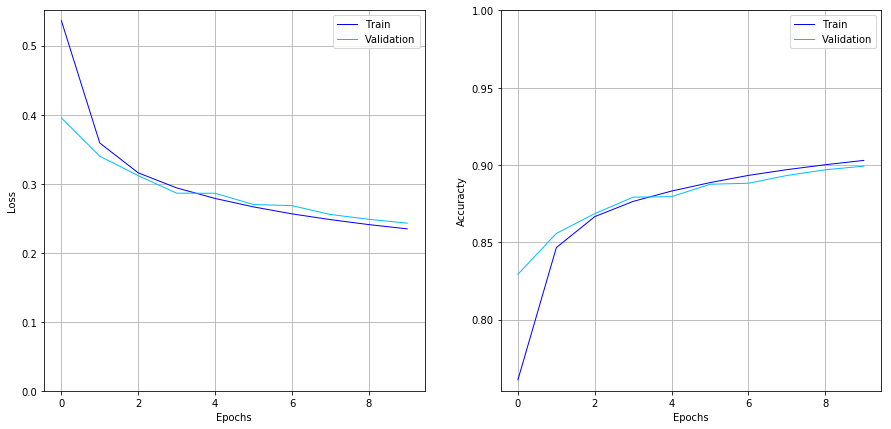

Saving summary...
Saving tensorboard logs...
All done saving stuff!
- 1: Freezing layer <keras.layers.convolutional.Conv2D object at 0x7f2121cadd30>
- 2: Freezing layer <keras.layers.convolutional.Conv2D object at 0x7f2121d0a6a0>
- 3: Freezing layer <keras.layers.convolutional.Conv2D object at 0x7f2121e90f98>
- 4: Resetting layer <keras.layers.convolutional.Conv2D object at 0x7f2121cde6d8>
- 5: Resetting layer <keras.layers.convolutional.Conv2D object at 0x7f211f913390>
- 6: Resetting layer <keras.layers.convolutional.Conv2D object at 0x7f2125fb7a90>
- 7: Resetting layer <keras.layers.convolutional.Conv2D object at 0x7f2121c6e4a8>
- 8: Skipping layer <keras.layers.core.Flatten object at 0x7f2121c88470>
- 9: Resetting layer <keras.layers.core.Dense object at 0x7f2121c88908>
Save dir: Results/572/
Creating save dir
Done generating results dir Results/572/
Train on 4982178 samples, validate on 2453910 samples
Epoch 1/10
4982178/4982178 [==============================] - 132s 27us/step - l

In [ ]:
%run -i 'arena.py'

for copyFirstNLayers in range(startTrainingAtLayer, layersCount):
    print('\n\n')
    print('==========================================================================================')
    print('=                                                                                        =')
    print('=                    Currently transfering first {} layers, out of {}                      ='.format(copyFirstNLayers, layersCount - 1))
    print('=                                                                                        =')
    print('==========================================================================================')
    print()
    
    # check if we are at the flatten layer, and skip it if so
    if copyFirstNLayers == layersCount - 1:
        copyFirstNLayers += 1
        
    # train and average results
    accumulatedScore = 0
    for a in range(averageOver):
        
        # set experement description test
        expDescr = expDescrBaseName + '__copyLayers_{}__average_{}_of_{}'.format(copyFirstNLayers, a+1, averageOver)        
        # save current averagePosition to tmp file
        with open(saveDir + '/' + str(resSaveFile) + '_currentPosition.txt','w') as file:
            if copyFirstNLayers == layersCount:
                location = copyFirstNLayers - 1
            else:
                location = copyFirstNLayers 
            file.write('Layers Transfered: {} out of {} \nInner avg loop position: {} out of {}'.format(location, layersCount-1, a+1, averageOver))         
            
        # load Model layers
        model = loadNFirstLayers(model, sourceNet, copyFirstNLayers , freeze)

        # Prepare save dir
        if saveEveryRun:
            resID = genNextResultsDir(model)

        # train
        fitHistory, logDir = trainModel(resID, model, saveWeightsCheckpoints, saveTensorboardLogs)

        # score and save results
        score = calcScore(model)
        if saveEveryRun:
            saveTrainResults(resID, model, logDir, score, copyFirstNLayers)

        # update Return
        accumulatedScore += score[1]
        
    # append averaged results for one set of layers
    results.append(accumulatedScore/averageOver)

    # save old results to checkpoints dir
    dateTime = time.strftime('%Y-%m-%d-%H:%M:%S', time.localtime())
    src = saveDir + '/' + str(resSaveFile) + '.txt'
    dest = saveDir + '/checkpoints/' + str(resSaveFile) + dateTime + '.txt'
    if os.path.exists(src):
        shutil.move(src, dest)

    # save results 
    save_obj(saveDir, resSaveFile, results)
    with open(saveDir + '/' + str(resSaveFile) + '.txt','w') as file:
        file.write(str(results))

    # to load:
    # results = load_obj('temp','3n4.txt')
print('\n Final Results: {}'.format(results))